# Project 4 OLIST - 01 : Data cleaning / EDA

In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.dates as mdates
import geopandas

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

Populating the interactive namespace from numpy and matplotlib


Flake8 activation to respect PEP8 (but ignoring too long lines errors) :

In [2]:
%load_ext pycodestyle_magic
%flake8_on -i E501

## Data import and visualizations

In [3]:
db_dict = {
    'customers': pd.read_csv('POLIST_04_data/olist_customers_dataset.csv', sep=','),
    'geolocation': pd.read_csv('POLIST_04_data/olist_geolocation_dataset.csv', sep=','),
    'order_items': pd.read_csv('POLIST_04_data/olist_order_items_dataset.csv', sep=','),
    'order_payments': pd.read_csv('POLIST_04_data/olist_order_payments_dataset.csv', sep=','),
    'order_reviews': pd.read_csv('POLIST_04_data/olist_order_reviews_dataset.csv', sep=','),
    'orders': pd.read_csv('POLIST_04_data/olist_orders_dataset.csv', sep=','),
    'products': pd.read_csv('POLIST_04_data/olist_products_dataset.csv', sep=','),
    'sellers': pd.read_csv('POLIST_04_data/olist_sellers_dataset.csv', sep=','),
    'product_category_name_translation': pd.read_csv('POLIST_04_data/product_category_name_translation.csv', sep=',')
}

for table in db_dict:
    print("{} : {} rows | {} columns | {} missing values | {} duplicates\n"
          .format(
                table,
                db_dict[table].shape[0],
                db_dict[table].shape[1],
                db_dict[table].isna().sum().sum(),
                db_dict[table].duplicated().sum()))

customers : 99441 rows | 5 columns | 0 missing values | 0 duplicates

geolocation : 1000163 rows | 5 columns | 0 missing values | 261831 duplicates

order_items : 112650 rows | 7 columns | 0 missing values | 0 duplicates

order_payments : 103886 rows | 5 columns | 0 missing values | 0 duplicates

order_reviews : 100000 rows | 7 columns | 146532 missing values | 0 duplicates

orders : 99441 rows | 8 columns | 4908 missing values | 0 duplicates

products : 32951 rows | 9 columns | 2448 missing values | 0 duplicates

sellers : 3095 rows | 4 columns | 0 missing values | 0 duplicates

product_category_name_translation : 71 rows | 2 columns | 0 missing values | 0 duplicates



!['MCD'](ressources/DBstructure.png)

In [4]:
def display_column_details(db: dict):
    '''
    Create a dataframe containing columns details for all tables
    :db: dict of dataframes
    outut: dataframe
    '''
    df = pd.DataFrame(columns=['table', 'column', 'type', 'missing', 'unique'])
    row = {}
    for table in db:
        row['table'] = table
        for col in db[table].columns:
            row['column'] = col
            row['type'] = db[table][col].dtype
            row['unique'] = db[table][col].nunique()
            row['missing'] = db[table][col].isna().sum()
            df = df.append(row, ignore_index=True)
    return df


display_column_details(db_dict)

,table,column,type,missing,unique
0,customers,customer_id,object,0,99441
1,customers,customer_unique_id,object,0,96096
2,customers,customer_zip_code_prefix,int64,0,14994
3,customers,customer_city,object,0,4119
4,customers,customer_state,object,0,27
5,geolocation,geolocation_zip_code_prefix,int64,0,19015
6,geolocation,geolocation_lat,float64,0,717360
7,geolocation,geolocation_lng,float64,0,717613
8,geolocation,geolocation_city,object,0,8011
9,geolocation,geolocation_state,object,0,27


Orders with the status 'canceled' or 'unavailable' may not have been approved and do not contain products / dates  
Customers may have noted an order without adding a title or message to the review  
There are also 2 categories without translations and some products with missing data

## Cleaning

### Types

In [5]:
for table in db_dict:
    for col in db_dict[table].columns:
        # dates as DateTime
        if any([sub in col for sub in ['date', '_at', 'timestamp']]):
            db_dict[table][col] = db_dict[table][col].astype('datetime64')
        # zipcodes as string
        if any([sub in col for sub in ['zip_code']]):
            db_dict[table][col] = db_dict[table][col].astype(str)
        # lower strings
        if db_dict[table][col].dtype == 'object':
            db_dict[table][col] = db_dict[table][col].str.lower()

### Null values

**Products**

In [6]:
db_dict['products'][db_dict['products']['product_category_name'].isnull()]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
105,a41e356c76fab66334f36de622ecbd3a,NaN,NaN,NaN,NaN,650.0,17.0,14.0,12.0
128,d8dee61c2034d6d075997acef1870e9b,NaN,NaN,NaN,NaN,300.0,16.0,7.0,20.0
145,56139431d72cd51f19eb9f7dae4d1617,NaN,NaN,NaN,NaN,200.0,20.0,20.0,20.0
154,46b48281eb6d663ced748f324108c733,NaN,NaN,NaN,NaN,18500.0,41.0,30.0,41.0
197,5fb61f482620cb672f5e586bb132eae9,NaN,NaN,NaN,NaN,300.0,35.0,7.0,12.0
...,...,...,...,...,...,...,...,...,...
32515,b0a0c5dd78e644373b199380612c350a,NaN,NaN,NaN,NaN,1800.0,30.0,20.0,70.0
32589,10dbe0fbaa2c505123c17fdc34a63c56,NaN,NaN,NaN,NaN,800.0,30.0,10.0,23.0
32616,bd2ada37b58ae94cc838b9c0569fecd8,NaN,NaN,NaN,NaN,200.0,21.0,8.0,16.0
32772,fa51e914046aab32764c41356b9d4ea4,NaN,NaN,NaN,NaN,1300.0,45.0,16.0,45.0


In [7]:
db_dict['products'][db_dict['products']['product_width_cm'].isnull()]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8578,09ff539a621711667c43eba6a3bd8466,bebes,60.0,865.0,3.0,NaN,NaN,NaN,NaN
18851,5eb564652db742ff8f28759cd8d2652a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Null values in the Products table correspond to products (which could be ordered) without name, description, photos but with weight, length, width.   
The reverse is true for one product.  
And there is no values for one other product.

In [8]:
# products table null values
db_dict['products']['product_category_name'].fillna('unknown', inplace=True)
db_dict['products']['product_name_lenght'].fillna(0, inplace=True)
db_dict['products']['product_description_lenght'].fillna(0, inplace=True)
db_dict['products']['product_photos_qty'].fillna(0, inplace=True)
# I obly modify the columns I'll use

**Translations**

In [9]:
# categories without translation
to_translate = db_dict['products']['product_category_name'][~db_dict['products']['product_category_name'].isin(db_dict['product_category_name_translation']['product_category_name'])].unique()  # noqa: E501
print('Missing translations :', to_translate)

Missing translations : ['unknown' 'pc_gamer' 'portateis_cozinha_e_preparadores_de_alimentos']


In [10]:
# adding translations
missing_translations = {
    'product_category_name': ['unknown', 'pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos'],
    'product_category_name_english': ['unknown', 'pc_gamer', 'portable_food_preparers']
}
db_dict['product_category_name_translation'] = db_dict['product_category_name_translation'].append(pd.DataFrame(missing_translations), ignore_index=True)

## Data Structure

### Computing new columns in tables

In [11]:
# orders delivery time
db_dict['orders']['delivery_time'] = pd.to_timedelta(db_dict['orders']['order_delivered_customer_date'] - db_dict['orders']['order_purchase_timestamp']).dt.days
# orders delivery delay
db_dict['orders']['delivery_delay'] = pd.to_timedelta(db_dict['orders']['order_delivered_customer_date'] - db_dict['orders']['order_estimated_delivery_date']).dt.days

In [12]:
# reviews text length
reviews_txt_stats = {
    'title_msg': 0,
    'msg': 0,
    'title': 0,
    'nothing': 0,
    'length_list': []
}
for row_id in db_dict['order_reviews'].index:
    if (db_dict['order_reviews']['review_comment_message'].iloc[row_id] is not np.nan) and (db_dict['order_reviews']['review_comment_title'].iloc[row_id] is not np.nan):  # mesage + title lentgh
        reviews_txt_stats['length_list'].append(len(db_dict['order_reviews']['review_comment_message'].iloc[row_id]) + len(db_dict['order_reviews']['review_comment_title'].iloc[row_id]))
        reviews_txt_stats['title_msg'] += 1
    elif db_dict['order_reviews']['review_comment_message'].iloc[row_id] is not np.nan:  # Just the message length
        reviews_txt_stats['length_list'].append(len(db_dict['order_reviews']['review_comment_message'].iloc[row_id]))
        reviews_txt_stats['msg'] += 1
    elif db_dict['order_reviews']['review_comment_title'].iloc[row_id] is not np.nan:  # Just the message length
        reviews_txt_stats['length_list'].append(len(db_dict['order_reviews']['review_comment_title'].iloc[row_id]))
        reviews_txt_stats['title'] += 1
    else:  # No title or message
        reviews_txt_stats['length_list'].append(0)
        reviews_txt_stats['nothing'] += 1
db_dict['order_reviews']['review_text_length'] = reviews_txt_stats['length_list']

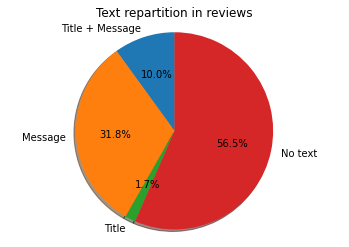

In [13]:
sizes = [reviews_txt_stats['title_msg'], reviews_txt_stats['msg'], reviews_txt_stats['title'], reviews_txt_stats['nothing']]
labels = ['Title + Message', 'Message', 'Title', 'No text']
fig, ax = plt.subplots(facecolor='white')
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Text repartition in reviews')
plt.show()

Reviews can contain a title and a message, just one of the two, or no text at all  
review_text_length is the sum of this 2 columns length

**Categories aggregation**

In [14]:
print(db_dict['product_category_name_translation']['product_category_name_english'].nunique())
db_dict['product_category_name_translation']['product_category_name_english'].unique()

74


array(['health_beauty', 'computers_accessories', 'auto', 'bed_bath_table',
       'furniture_decor', 'sports_leisure', 'perfumery', 'housewares',
       'telephony', 'watches_gifts', 'food_drink', 'baby', 'stationery',
       'tablets_printing_image', 'toys', 'fixed_telephony',
       'garden_tools', 'fashion_bags_accessories', 'small_appliances',
       'consoles_games', 'audio', 'fashion_shoes', 'cool_stuff',
       'luggage_accessories', 'air_conditioning',
       'construction_tools_construction',
       'kitchen_dining_laundry_garden_furniture',
       'costruction_tools_garden', 'fashion_male_clothing', 'pet_shop',
       'office_furniture', 'market_place', 'electronics',
       'home_appliances', 'party_supplies', 'home_confort',
       'costruction_tools_tools', 'agro_industry_and_commerce',
       'furniture_mattress_and_upholstery', 'books_technical',
       'home_construction', 'musical_instruments',
       'furniture_living_room', 'construction_tools_lights',
       'indust

In [15]:
categ_agg = {
    # food_drinks
    'food_drink': 'food_drinks',
    'food': 'food_drinks',
    'drinks': 'food_drinks',

    # home
    'furniture_living_room': 'home',
    'furniture_mattress_and_upholstery': 'home',
    'furniture_bedroom': 'home',
    'furniture_decor': 'home',
    'bed_bath_table': 'home',
    'kitchen_dining_laundry_garden_furniture': 'home',
    'la_cuisine': 'home',
    'home_confort': 'home',
    'home_comfort_2': 'home',
    'christmas_supplies': 'home',
    'housewares': 'home',

    # appliances
    'small_appliances': 'appliances',
    'small_appliances_home_oven_and_coffee': 'appliances',
    'home_appliances_2': 'appliances',
    'home_appliances': 'appliances',
    'portable_food_preparers': 'home',

    # construction
    'construction_tools_construction': 'construction',
    'costruction_tools_garden': 'construction',
    'costruction_tools_tools': 'construction',
    'construction_tools_safety': 'construction',
    'construction_tools_lights': 'construction',
    'home_construction': 'construction',
    'air_conditioning': 'construction',

    # office
    'office_furniture': 'office',
    'industry_commerce_and_business': 'office',
    'stationery': 'office',
    'agro_industry_and_commerce': 'office',
    'signaling_and_security': 'office',
    'security_and_services': 'office',
    'market_place': 'office',

    # electronics
    'telephony': 'electronics',
    'electronics': 'electronics',
    'computers_accessories': 'electronics',
    'consoles_games': 'electronics',
    'fixed_telephony': 'electronics',
    'audio': 'electronics',
    'computers': 'electronics',
    'tablets_printing_image': 'electronics',
    'pc_gamer': 'electronics',

    # hobbies
    'sports_leisure': 'hobbies',
    'musical_instruments': 'hobbies',
    'party_supplies': 'hobbies',
    'luggage_accessories': 'hobbies',
    'toys': 'hobbies',
    'cool_stuff': 'hobbies',
    'books_imported': 'hobbies',
    'books_general_interest': 'hobbies',
    'books_technical': 'hobbies',
    'art': 'hobbies',
    'cine_photo': 'hobbies',
    'cds_dvds_musicals': 'hobbies',
    'music': 'hobbies',
    'dvds_blu_ray': 'hobbies',
    'arts_and_craftmanship': 'hobbies',

    # clothing and accessories
    'watches_gifts': 'clothing_accessories',
    'fashion_bags_accessories': 'clothing_accessories',
    'fashion_underwear_beach': 'clothing_accessories',
    'fashion_shoes': 'clothing_accessories',
    'fashion_male_clothing': 'clothing_accessories',
    'fashio_female_clothing': 'clothing_accessories',
    'fashion_sport': 'clothing_accessories',
    'fashion_childrens_clothes': 'clothing_accessories',

    # health and beauty
    'health_beauty': 'health_beauty',
    'baby': 'health_beauty',
    'diapers_and_hygiene': 'health_beauty',
    'perfumery': 'health_beauty',

    # garden and pets
    'flowers': 'garden_pets',
    'pet_shop': 'garden_pets',
    'garden_tools': 'garden_pets',

    # auto
    'auto': 'auto',

    # unknown
    'unknown': 'unknown'
}

In [16]:
db_dict['product_category_name_translation']['product_category_agg'] = ''
for i in db_dict['product_category_name_translation'].index:
    db_dict['product_category_name_translation']['product_category_agg'].iloc[i] = categ_agg[db_dict['product_category_name_translation']['product_category_name_english'].iloc[i]]

### Merging tables

In [17]:
# add products to order items
db_df = pd.merge(left=db_dict['order_items'], right=db_dict['products'], on='product_id', how='left')
# add sellers to order items
db_df = pd.merge(left=db_df, right=db_dict['sellers'], on='seller_id', how='left')
# add order items to orders
db_df = pd.merge(left=db_dict['orders'], right=db_df, on='order_id', how='left')
# add order reviews to orders
db_df = pd.merge(left=db_df, right=db_dict['order_reviews'], on='order_id', how='left')
# add order payments to orders
db_df = pd.merge(left=db_df, right=db_dict['order_payments'], on='order_id', how='left')
# add orders to customers
db_df = pd.merge(left=db_dict['customers'], right=db_df, on='customer_id', how='left')
# add traduction to products
db_df = pd.merge(left=db_df, right=db_dict['product_category_name_translation'], on='product_category_name', how='left')


In [18]:
print("Database dataframe : {} rows / {} columns".format(db_df.shape[0], db_df.shape[1]))

Database dataframe : 119151 rows / 44 columns


<AxesSubplot:>

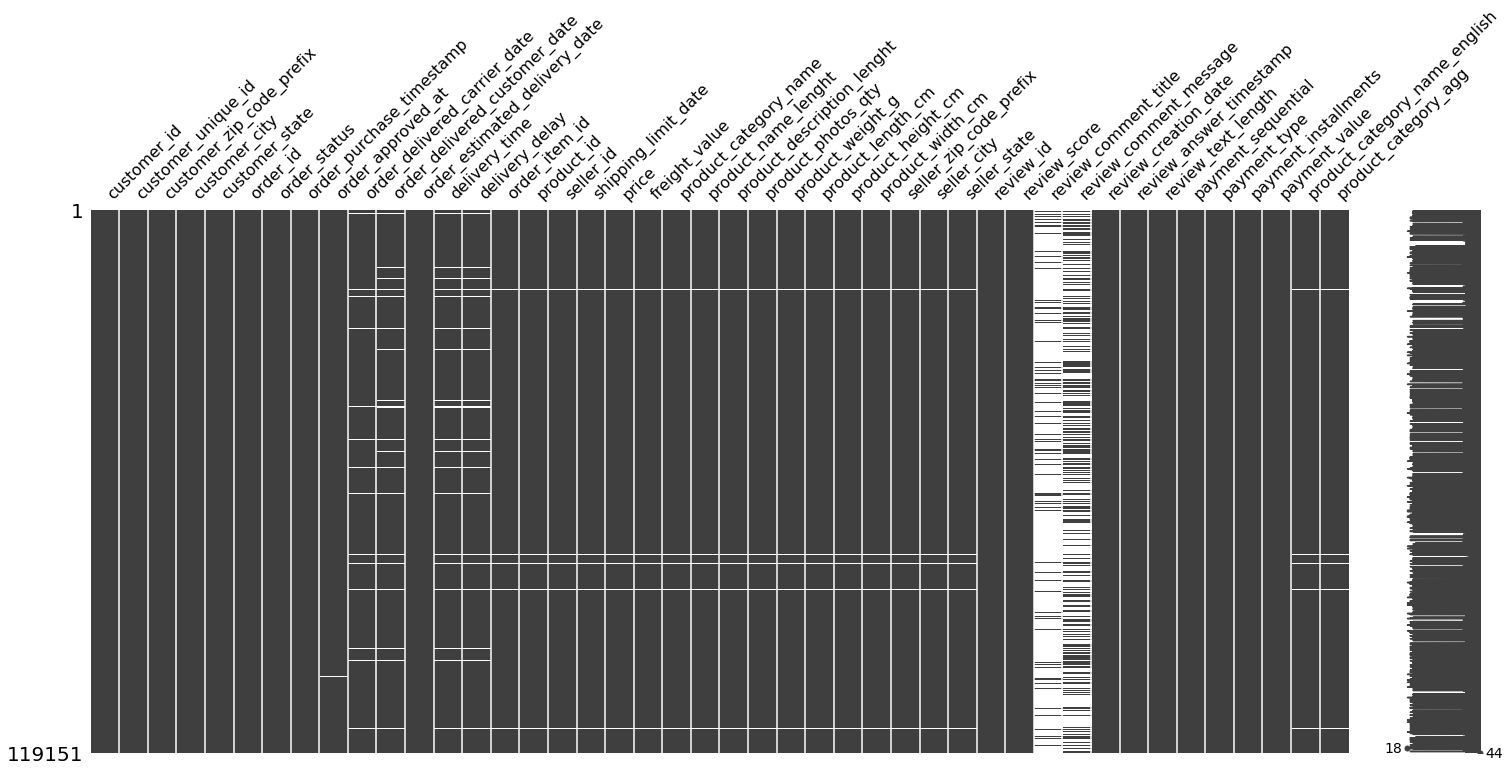

In [19]:
msno.matrix(db_df)

### Features engineering

In [20]:
# number of orders per customer
df = pd.DataFrame(data={'nb_orders': db_df.groupby('customer_unique_id')['customer_id'].nunique(dropna=True)})

# total number of products ordered per customer
df['total_products_ordered'] = db_df.groupby(['customer_unique_id', 'order_id'])['order_item_id'].max().groupby('customer_unique_id').sum()

# mean number of product per order
df['mean_nb_products'] = db_df.groupby(['customer_unique_id', 'order_id'])['order_item_id'].max().groupby('customer_unique_id').mean()

# total paid
df['total_paid'] = db_df.groupby('customer_unique_id')['price'].sum()

# mean order price
df['mean_order_price'] = db_df.groupby(['customer_unique_id', 'order_id'])['price'].sum().groupby('customer_unique_id').mean()

# mean product price
df['mean_product_price'] = db_df.groupby('customer_unique_id')['price'].mean()

# mean description length for ordered products
df['mean_prod_descr_length'] = db_df.groupby('customer_unique_id')['product_description_lenght'].mean()

# mean photos qty for ordered products
df['mean_photo_qty_for_ordered_prods'] = db_df.groupby('customer_unique_id')['product_photos_qty'].mean()

# mean review score
df['mean_reviews_score'] = db_df.groupby('customer_unique_id')['review_score'].mean()

# total number of reviews
df['nb_reviews'] = db_df.groupby('customer_unique_id')['review_id'].nunique()

# mean review messages length
df['mean_reviews_txt_length'] = db_df.groupby('customer_unique_id')['review_text_length'].mean()

# first order date
df['first_order_date'] = db_df.groupby('customer_unique_id')['order_purchase_timestamp'].min()

# days since the last order
df['recency'] = pd.to_timedelta(db_df['order_purchase_timestamp'].max() - df['first_order_date']).dt.days

# mean delivery time
df['mean_delivery_time'] = db_df.groupby('customer_unique_id')['delivery_time'].mean(numeric_only=False)

# mean delivery delay
df['mean_delivery_delay'] = db_df.groupby('customer_unique_id')['delivery_delay'].mean(numeric_only=False)

In [21]:
# Orders without products (status = cancelled/unavailable) cause divisions by 0 on the columns showing averages and therefore null values
# same for order without review messages
for col in df.columns:
    if 'mean' in col:
        df[col].fillna(0, inplace=True)

In [22]:
def mode_w_nan(series):
    '''
    Wrapper of the pandas mode function to handle null values
    '''
    if all(([x is np.nan for x in series])):
        return 'unknown'
    return pd.Series.mode(series)[0]  # if multiple items are returned, take the first


# favorite product category
df['favorite_category'] = db_df.groupby('customer_unique_id')['product_category_agg'].agg(mode_w_nan)

# favorite payment type
df['favorite_payment_type'] = db_df.groupby('customer_unique_id')['payment_type'].agg(mode_w_nan)

# favorite seller id
df['favorite_seller_id'] = db_df.groupby('customer_unique_id')['seller_id'].agg(mode_w_nan)

In [23]:
# adding customer zip code + city + state
df = df.join(db_dict['customers'][['customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']].drop_duplicates(subset='customer_unique_id').set_index('customer_unique_id'))

In [24]:
df

,nb_orders,total_products_ordered,mean_nb_products,total_paid,mean_order_price,mean_product_price,mean_prod_descr_length,mean_photo_qty_for_ordered_prods,mean_reviews_score,nb_reviews,mean_reviews_txt_length,first_order_date,recency,mean_delivery_time,mean_delivery_delay,favorite_category,favorite_payment_type,favorite_seller_id,customer_zip_code_prefix,customer_city,customer_state
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,1.0,1.0,129.90,129.90,129.90,236.0,1.0,5.0,1,126.0,2018-05-10 10:56:27,160,6.0,-5.0,home,credit_card,da8622b14eb17ae2831f4ac5b9dab84a,7787,cajamar,sp
0000b849f77a49e4a4ce2b2a4ca5be3f,1,1.0,1.0,18.90,18.90,18.90,635.0,1.0,4.0,1,0.0,2018-05-07 11:11:27,163,3.0,-5.0,health_beauty,credit_card,138dbe45fc62f1e244378131a6801526,6053,osasco,sp
0000f46a3911fa3c0805444483337064,1,1.0,1.0,69.00,69.00,69.00,177.0,3.0,3.0,1,0.0,2017-03-10 21:05:03,585,25.0,-2.0,office,credit_card,3d871de0142ce09b7081e2b9d1733cb1,88115,sao jose,sc
0000f6ccb0745a6a4b88665a16c9f078,1,1.0,1.0,25.99,25.99,25.99,1741.0,5.0,4.0,1,12.0,2017-10-12 20:29:41,369,20.0,-12.0,electronics,credit_card,ef506c96320abeedfb894c34db06f478,66812,belem,pa
0004aac84e0df4da2b147fca70cf8255,1,1.0,1.0,180.00,180.00,180.00,794.0,3.0,5.0,1,0.0,2017-11-14 19:45:42,336,13.0,-8.0,electronics,credit_card,70a12e78e608ac31179aea7f8422044b,18040,sorocaba,sp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1,2.0,2.0,1570.00,1570.00,785.00,478.5,1.0,5.0,1,0.0,2017-06-08 21:00:36,495,27.0,-27.0,health_beauty,credit_card,17f51e7198701186712e53a39c564617,55250,sanharo,pe
fffea47cd6d3cc0a88bd621562a9d061,1,1.0,1.0,64.89,64.89,64.89,506.0,2.0,4.0,1,0.0,2017-12-10 20:07:56,310,30.0,-3.0,health_beauty,credit_card,7aa4334be125fcdd2ba64b3180029f14,44054,feira de santana,ba
ffff371b4d645b6ecea244b27531430a,1,1.0,1.0,89.90,89.90,89.90,716.0,5.0,5.0,1,0.0,2017-02-07 15:49:16,617,14.0,-30.0,auto,credit_card,54aa8463e87776b5612f4bdc4bd5d4de,78552,sinop,mt


In [25]:
print("Final dataframe : {} rows / {} columns".format(df.shape[0], df.shape[1]))

Final dataframe : 96096 rows / 21 columns


<AxesSubplot:>

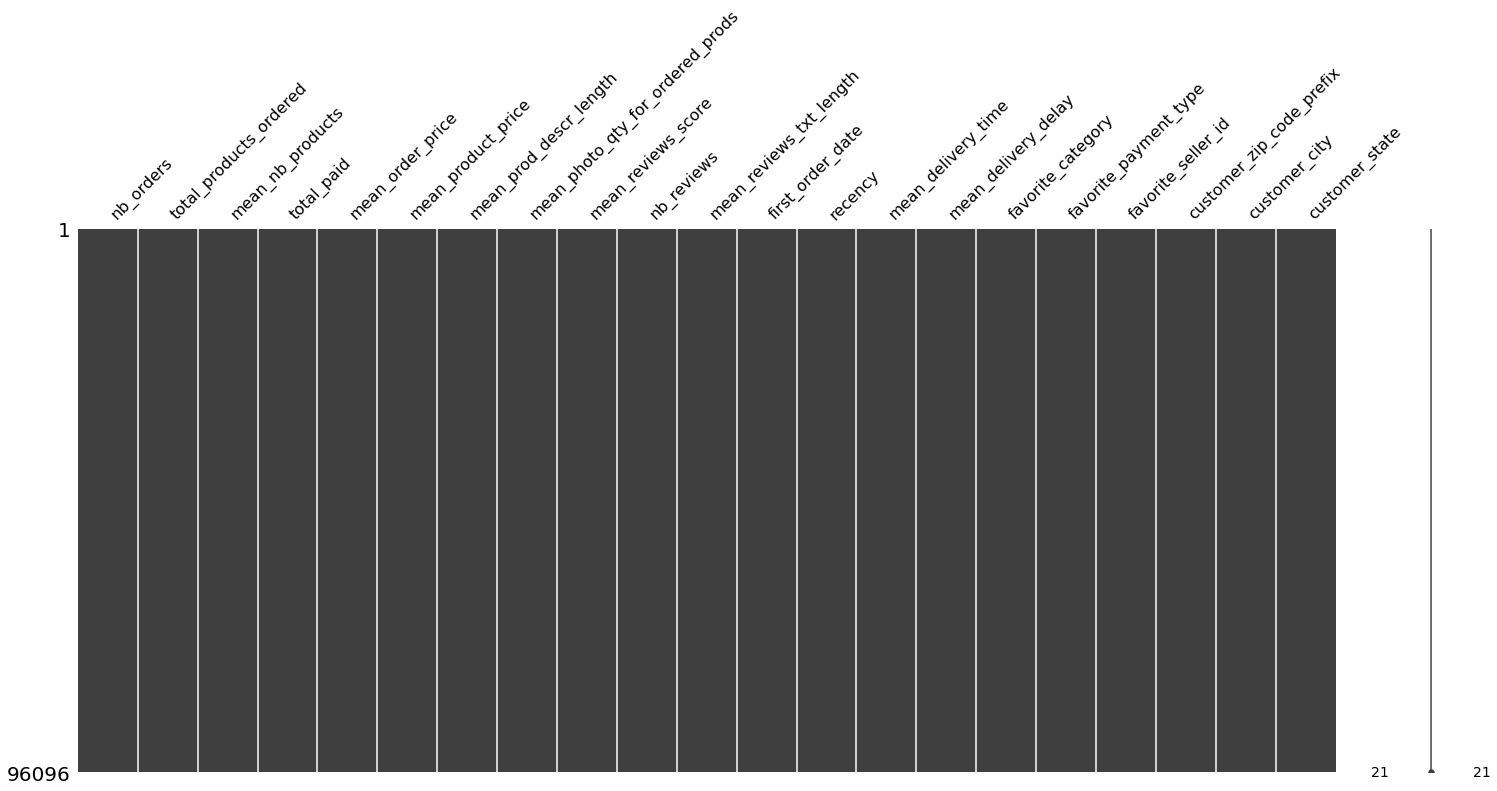

In [26]:
msno.matrix(df)

In [27]:
# display columns type
df.dtypes.sort_values()

nb_orders                                    int64
recency                                      int64
mean_delivery_delay                        float64
mean_delivery_time                         float64
first_order_date                    datetime64[ns]
nb_reviews                                   int64
mean_reviews_score                         float64
mean_reviews_txt_length                    float64
mean_prod_descr_length                     float64
mean_product_price                         float64
mean_order_price                           float64
total_paid                                 float64
mean_nb_products                           float64
total_products_ordered                     float64
mean_photo_qty_for_ordered_prods           float64
customer_city                               object
favorite_category                           object
favorite_payment_type                       object
favorite_seller_id                          object
customer_zip_code_prefix       

## EDA

### Univarite Analysis

#### Numerical features

In [28]:
df.describe()

,nb_orders,total_products_ordered,mean_nb_products,total_paid,mean_order_price,mean_product_price,mean_prod_descr_length,mean_photo_qty_for_ordered_prods,mean_reviews_score,nb_reviews,mean_reviews_txt_length,recency,mean_delivery_time,mean_delivery_delay
count,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000
mean,1.034809,1.172265,1.131087,148.548964,143.751683,125.631677,778.821098,2.207127,4.069267,1.032020,30.750457,290.458552,11.757003,-11.513017
std,0.214384,0.627071,0.533585,249.382240,241.701935,191.368345,653.405372,1.746620,1.353879,0.206015,50.629356,153.903666,9.628972,10.189510
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-147.000000
25%,1.000000,1.000000,1.000000,47.900000,46.900000,41.490000,342.000000,1.000000,4.000000,1.000000,0.000000,166.000000,6.000000,-17.000000
50%,1.000000,1.000000,1.000000,89.900000,89.000000,79.000000,599.000000,1.500000,5.000000,1.000000,0.000000,272.000000,10.000000,-12.000000
75%,1.000000,1.000000,1.000000,159.900000,153.785000,139.900000,985.000000,3.000000,5.000000,1.000000,46.000000,400.000000,15.000000,-7.000000
max,17.000000,24.000000,21.000000,13440.000000,13440.000000,6735.000000,3992.000000,20.000000,5.000000,17.000000,228.000000,772.000000,209.000000,188.000000


In [29]:
print('There are only {:.3}% of customers who have made more than one order'.format((df[df['nb_orders'] > 1].shape[0] / df.shape[0]) * 100))

There are only 3.12% of customers who have made more than one order


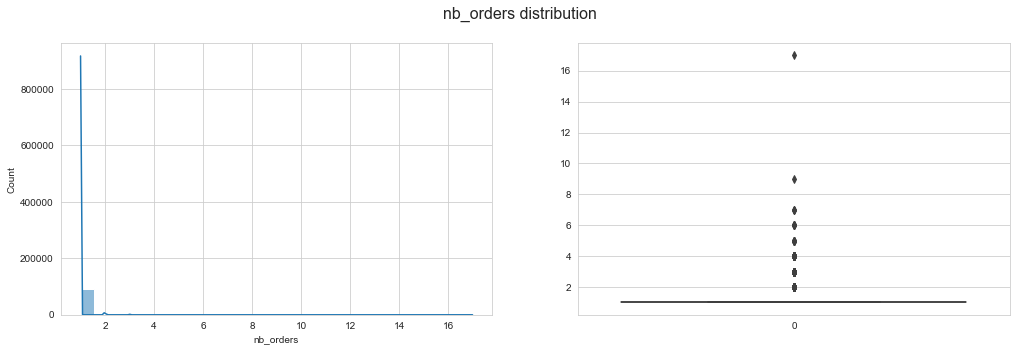

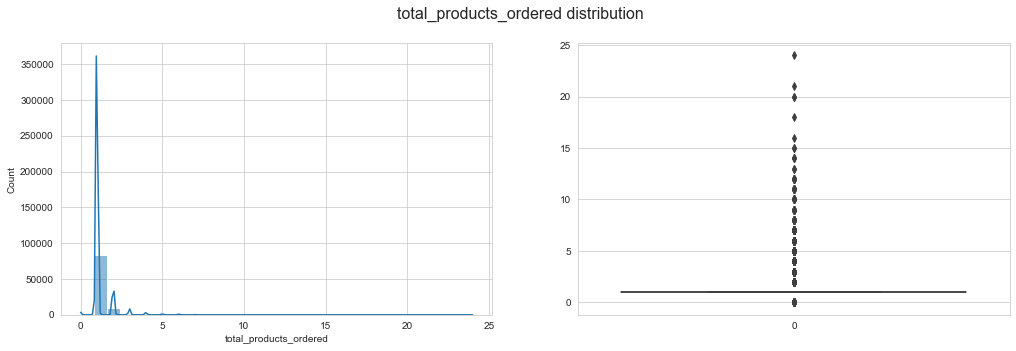

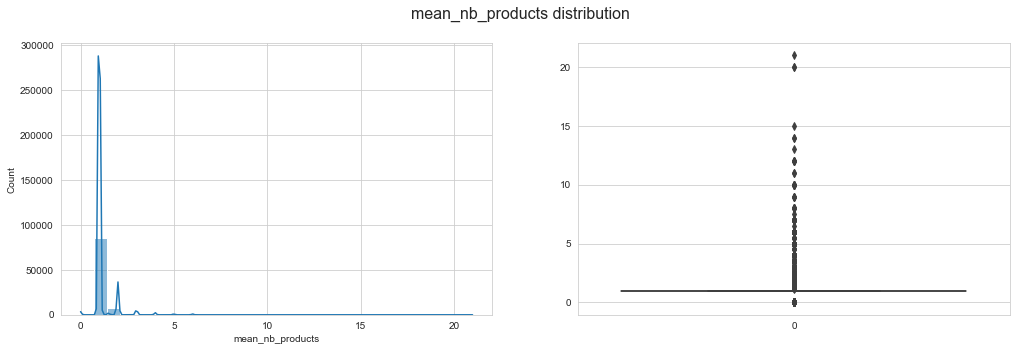

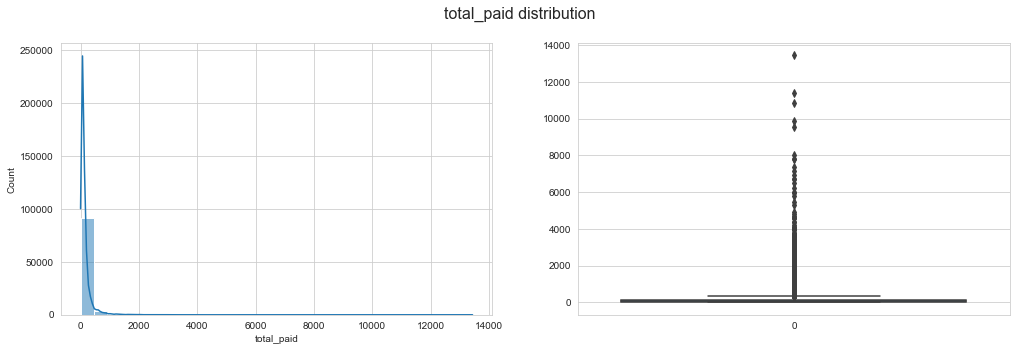

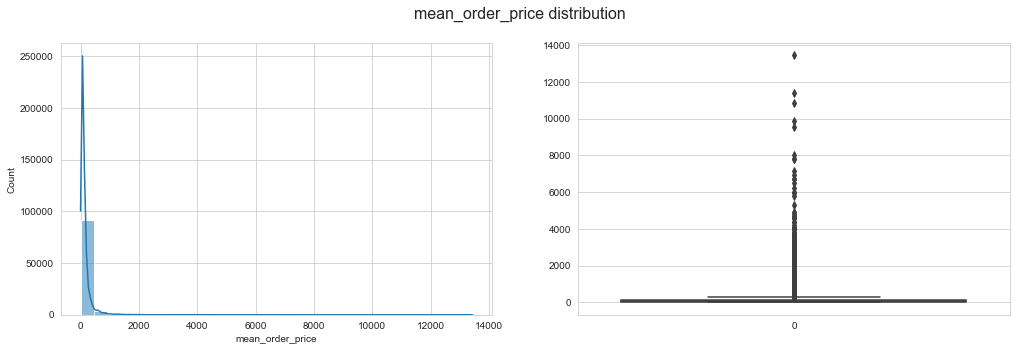

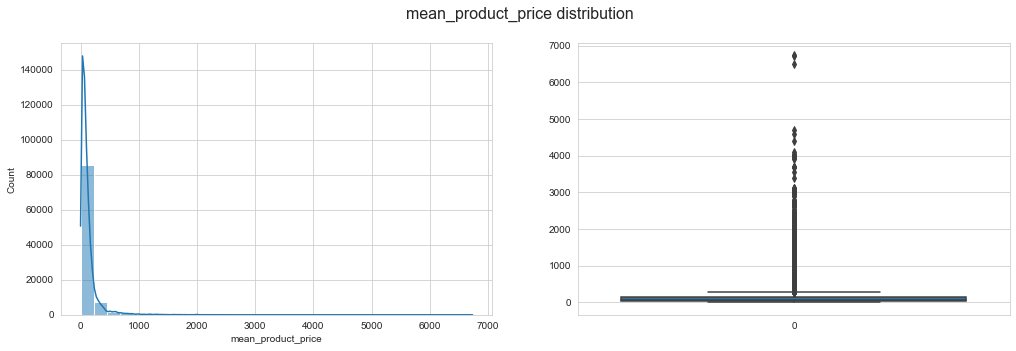

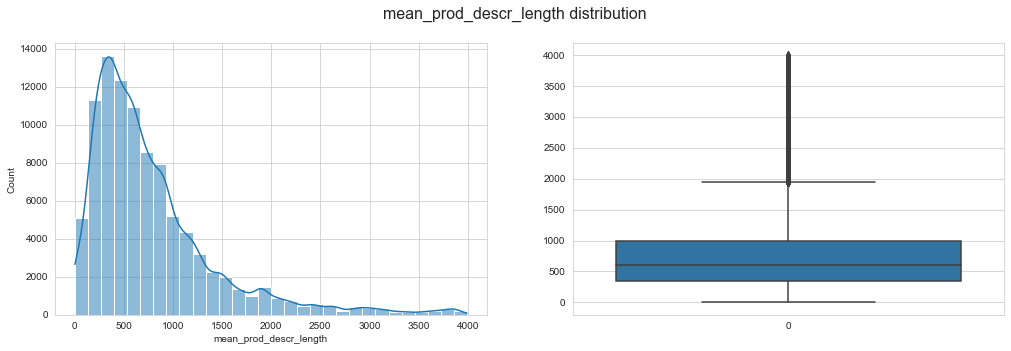

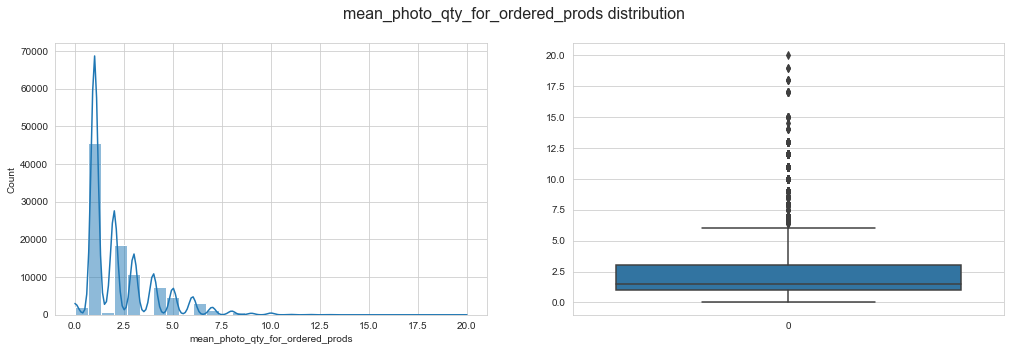

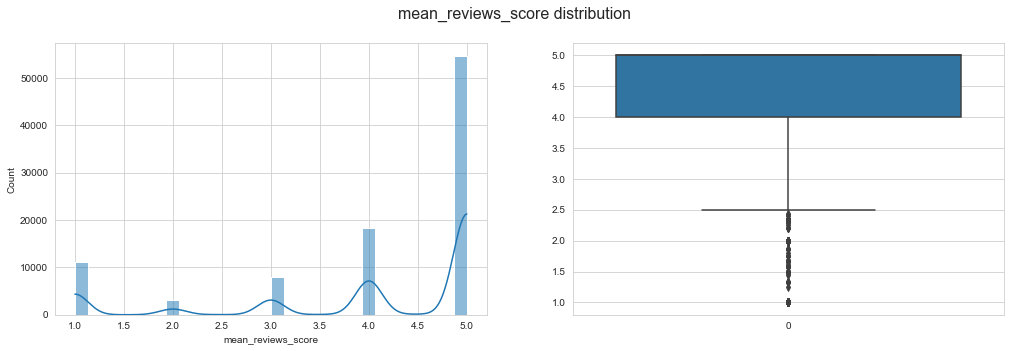

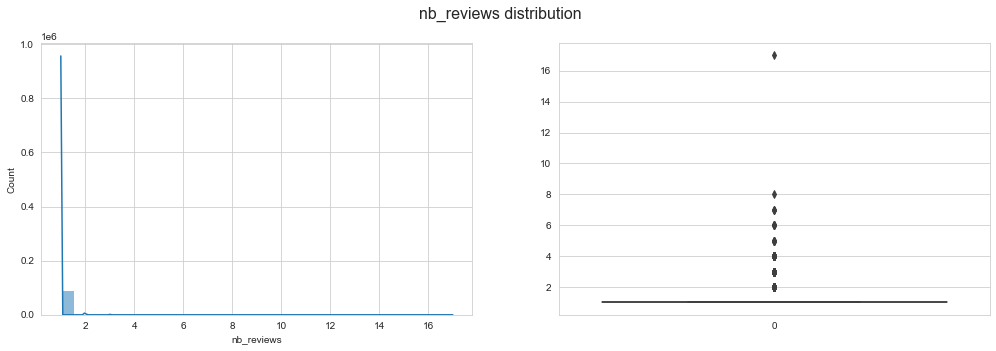

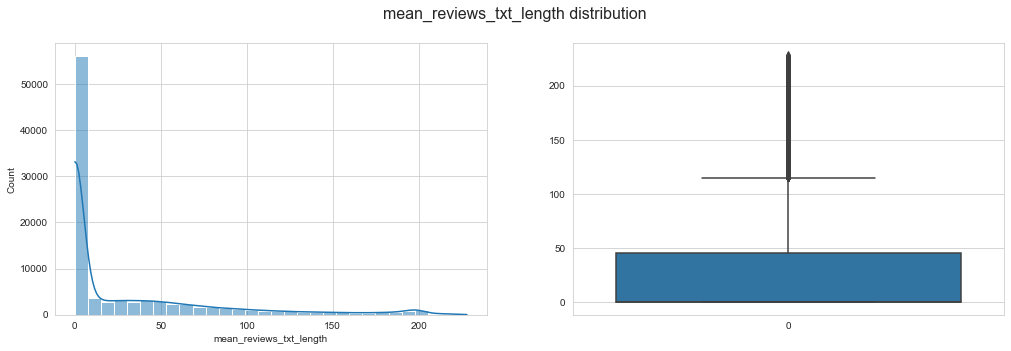

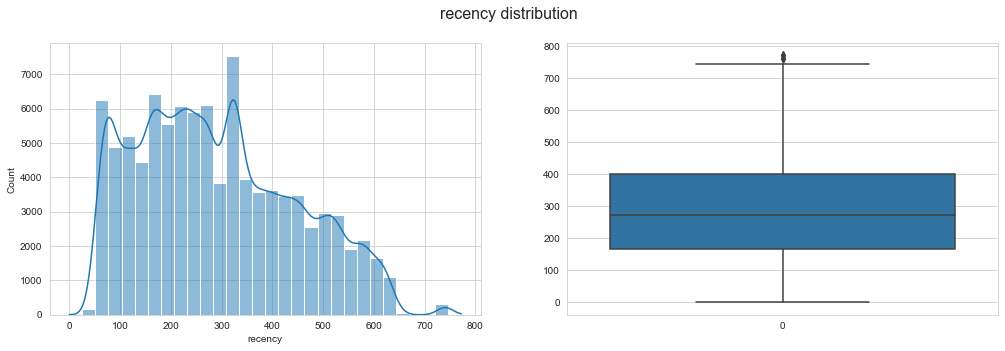

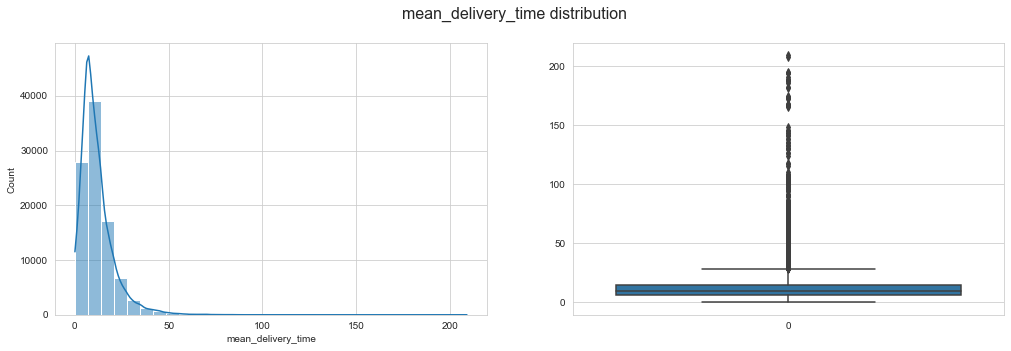

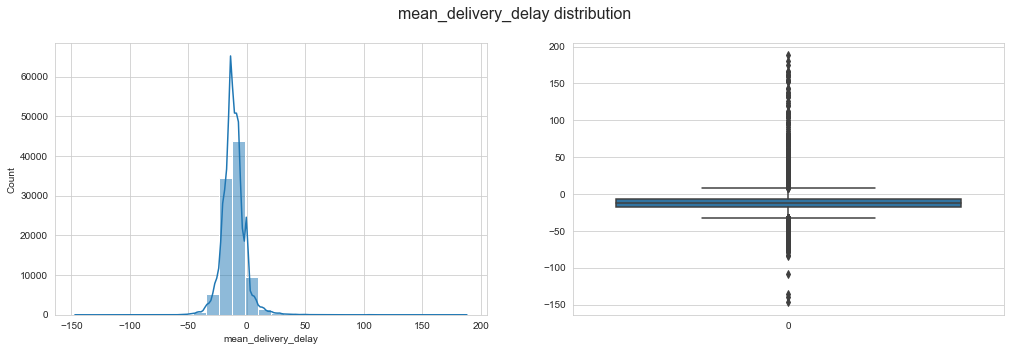

In [30]:
sns.set_style("whitegrid")
for column in df.select_dtypes(['int64', 'float64']).columns:
    f, axes = plt.subplots(1, 2, figsize=(17, 5))
    f.suptitle('{} distribution'.format(column), fontsize=16)
    sns.histplot(data=df[column], bins=30, ax=axes[0], kde=True)
    sns.boxplot(data=df[column], ax=axes[1])
    plt.show()

- Most features do not follow a normal distribution
- The majority of customers made 1 or 2 orders and ordered less than 5 products
- The majority of customers rated their orders between 4 and 5
- On average, orders arrive before the scheduled date (negatives values for mean_delivery_delay)

#### Categorical features

In [31]:
def display_top_X(data, col, x, title, color=None, lab_rot=90):
    '''Display a bar plot to show categories with the most occurrences
    input:
        data: DataFrame - grouped dataset
        col: str - categorical feature
        x: int - number of categories to display
        title: str - title of the plot
    '''
    top = df[col].value_counts().sort_values(ascending=False)
    if x:
        top = top.head(x)
    f, ax = plt.subplots(figsize=(15, 10))
    if color:
        sns.barplot(x=top.index, y=top.values, color=color)
    else:
        sns.barplot(x=top.index, y=top.values, palette='muted')
    plt.title(title, fontsize=13)
    plt.ylabel('Count of Customers')
    plt.xticks(rotation=lab_rot, fontsize=10)
    plt.show()

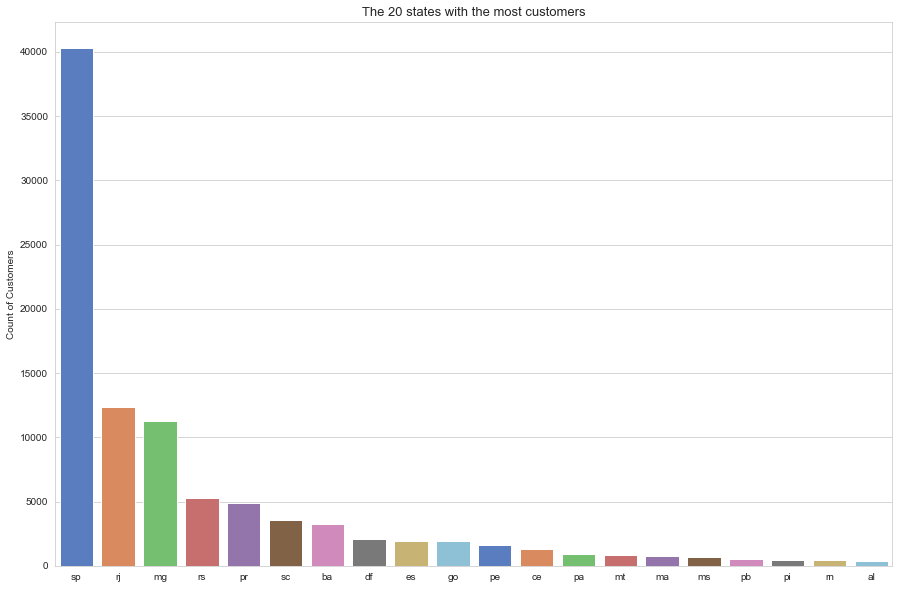

The customers comes from 27 different states


In [32]:
display_top_X(df, 'customer_state', 20, 'The 20 states with the most customers', lab_rot=0)
print('The customers comes from {} different states'.format(df['customer_state'].nunique()))

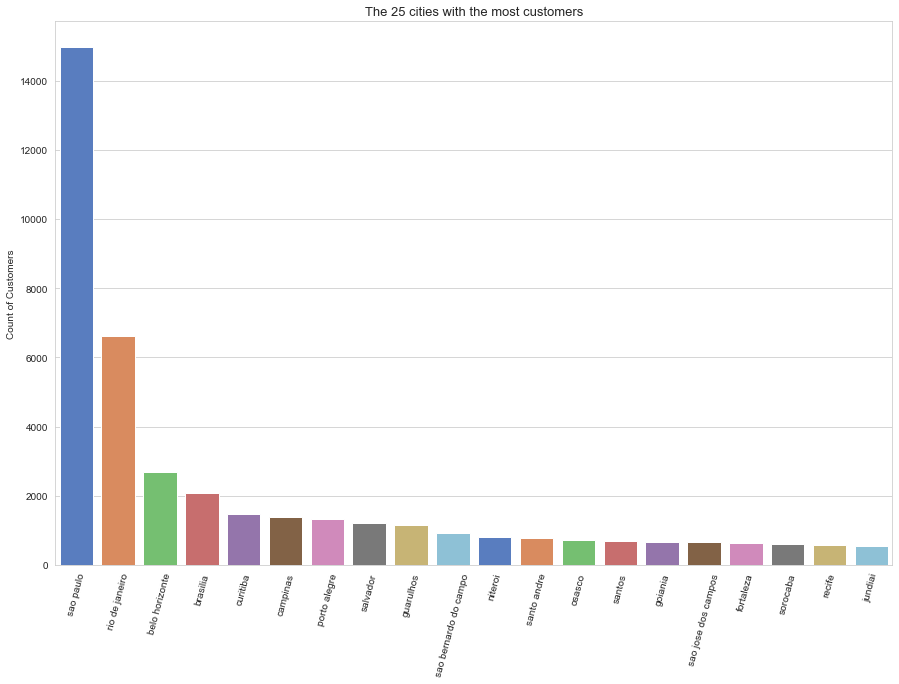

The customers comes from 4118 different cities


In [33]:
display_top_X(df, 'customer_city', 20, 'The 25 cities with the most customers', lab_rot=75)
print('The customers comes from {} different cities'.format(df['customer_city'].nunique()))

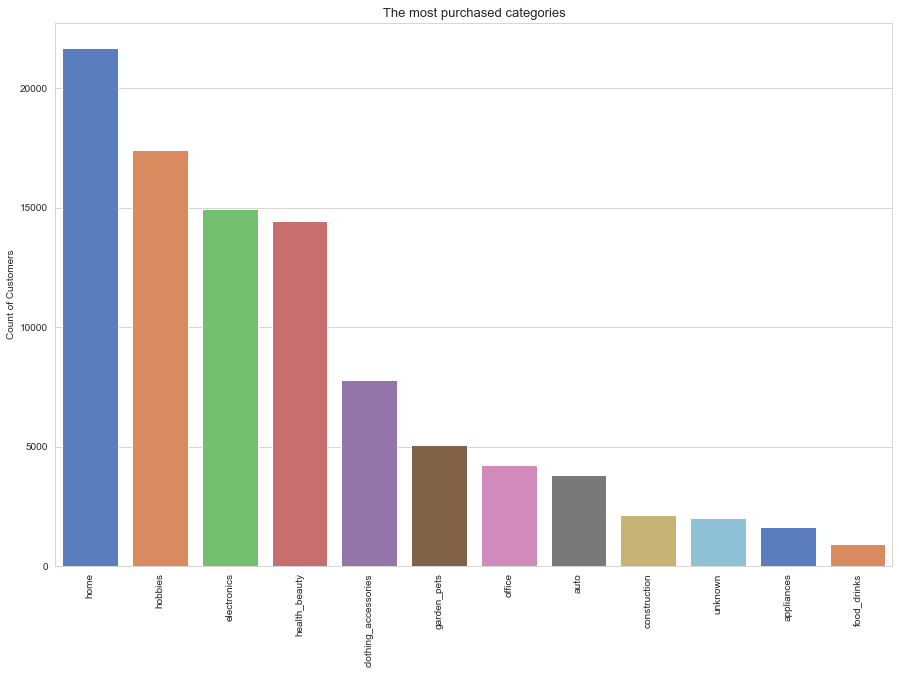

In [34]:
display_top_X(df, 'favorite_category', None, 'The most purchased categories')

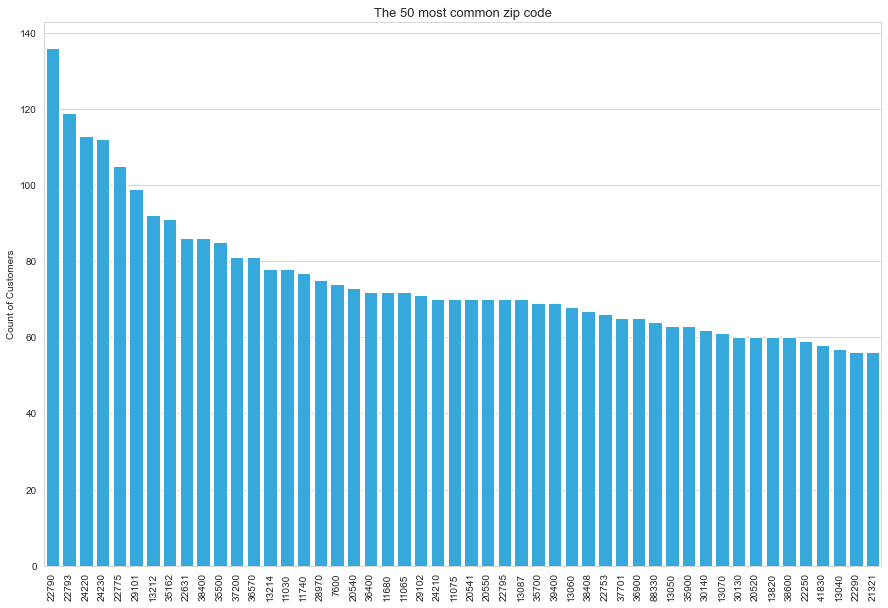

The customers comes from 14982 different neighborhood


In [35]:
display_top_X(df, 'customer_zip_code_prefix', 50, 'The 50 most common zip code', color='#1bb2f7')
print('The customers comes from {} different neighborhood'.format(df['customer_zip_code_prefix'].nunique()))

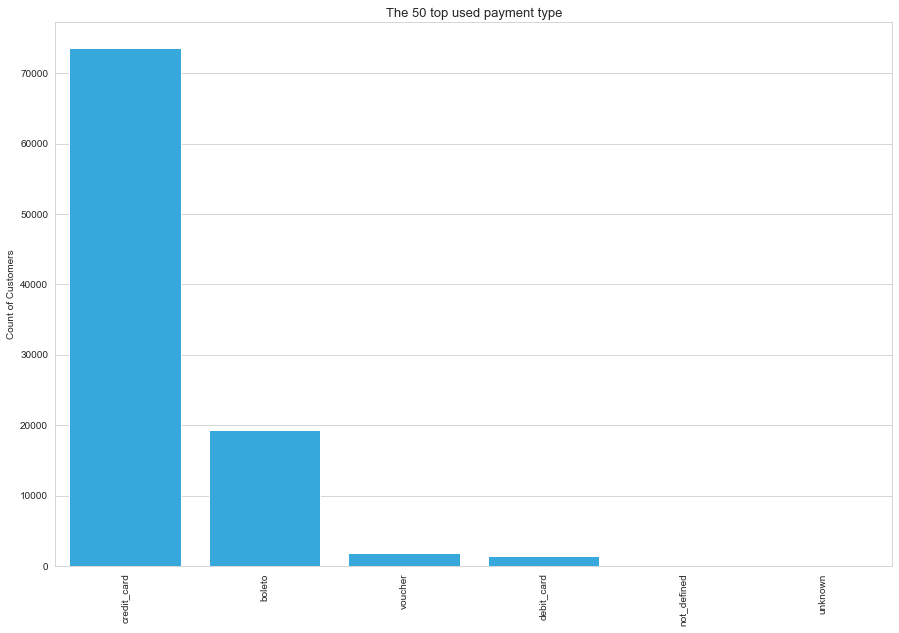

6 different payment type


In [36]:
display_top_X(df, 'favorite_payment_type', 50, 'The 50 top used payment type', color='#1bb2f7')
print('{} different payment type'.format(df['favorite_payment_type'].nunique()))

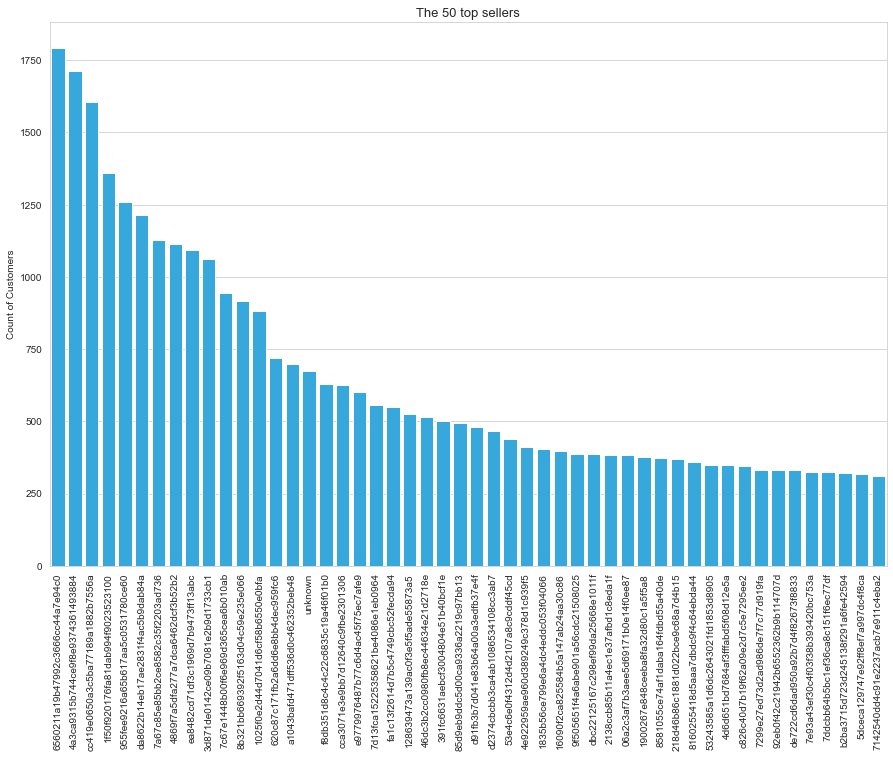

The ordered products comes from 3068 different sellers


In [37]:
display_top_X(df, 'favorite_seller_id', 50, 'The 50 top sellers', color='#1bb2f7')
print('The ordered products comes from {} different sellers'.format(df['favorite_seller_id'].nunique()))

Some of these columns contain so many unique values that it can be problematic when encoding them (for clustering)

#### Time Series

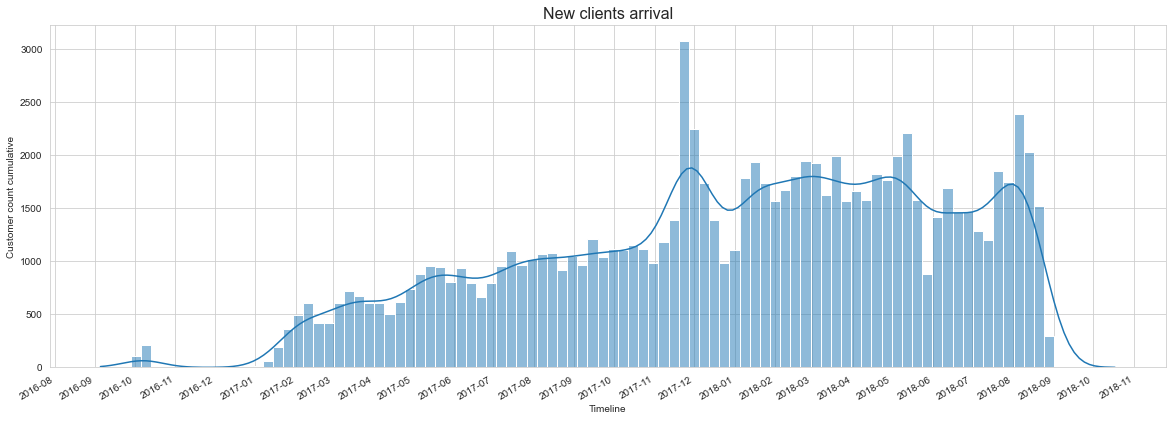

In [38]:
f, ax = plt.subplots(figsize=(20, 7))
sns.histplot(data=df['first_order_date'], bins=100, kde=True, ax=ax)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.title('New clients arrival', fontsize=16)
plt.xlabel('Timeline')
plt.ylabel('Customer count cumulative')
plt.show()

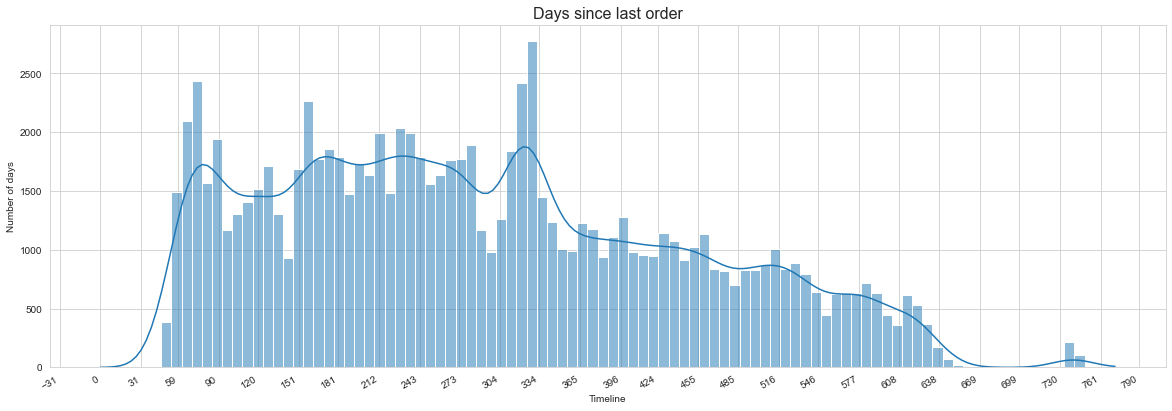

In [39]:
f, ax = plt.subplots(figsize=(20, 7))
sns.histplot(data=df['recency'], bins=100, kde=True, ax=ax)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.title('Days since last order', fontsize=16)
plt.xlabel('Timeline')
plt.ylabel('Number of days')
plt.show()

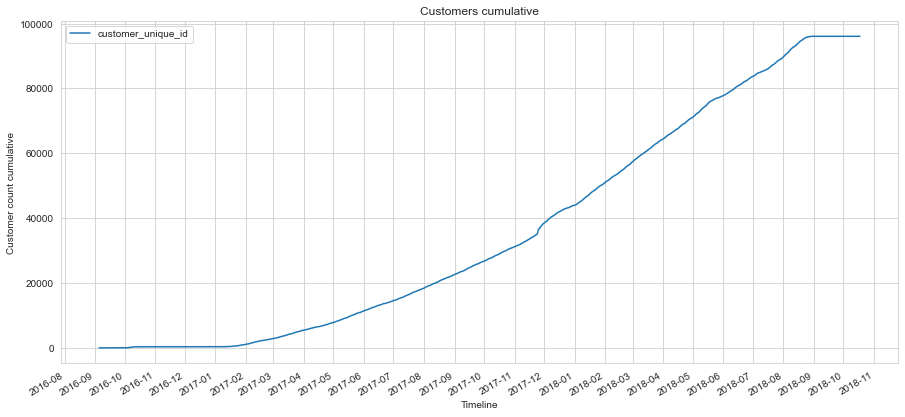

In [40]:
ax = df.reset_index()[['customer_unique_id', 'first_order_date']].groupby('first_order_date').count().cumsum().plot(figsize=(15, 7))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.title('Customers cumulative')
plt.xlabel('Timeline')
plt.ylabel('Customer count cumulative')
plt.show()

### Bivariate Analysis

#### Geographical positions

In [41]:
# adding the geolocation of each customers
df_cust_geo = pd.merge(left=df['customer_zip_code_prefix'], right=db_dict['geolocation'][['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']].groupby('geolocation_zip_code_prefix').median(), left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left').set_axis(df.index)

For a single zip code prefix, several longitude and latitude are associated.   
And since the position of customers is represented only by their zip code, I use the median latitude and longitude, which positions them close to the center of their neighborhood.  
I'm not adding these columns to the final dataset because there are some zip code with no latitude/longitude in the geolocation table

Text(265.31439940867983, 0.5, 'Latitude')

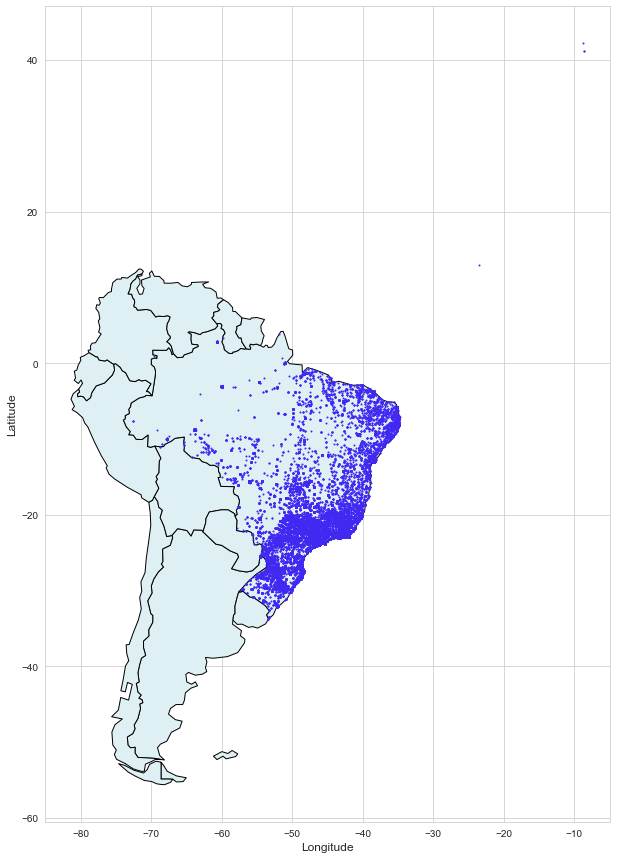

In [42]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world[world.continent == 'South America'].plot(figsize=(15, 15), edgecolor='black', color='#dff0f5')
ax.scatter(df_cust_geo['geolocation_lng'], df_cust_geo['geolocation_lat'], c='#4129f2', s=1, alpha=1)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

#### Incomes analysis

In [43]:
def incomes_analysis(df, group_by, title, top=None, lab_rot=90, color=None):
    f, ax = plt.subplots(figsize=(15, 10))
    incomes_by_states = df.groupby(group_by)['total_paid'].mean().sort_values(ascending=False)
    if top:
        incomes_by_states = incomes_by_states.head(top)
    if color:
        sns.barplot(x=incomes_by_states.index, y=incomes_by_states.values, color=color, ax=ax)
    else:
        sns.barplot(x=incomes_by_states.index, y=incomes_by_states.values, palette='muted', ax=ax)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=lab_rot, fontsize=13)
    plt.show()

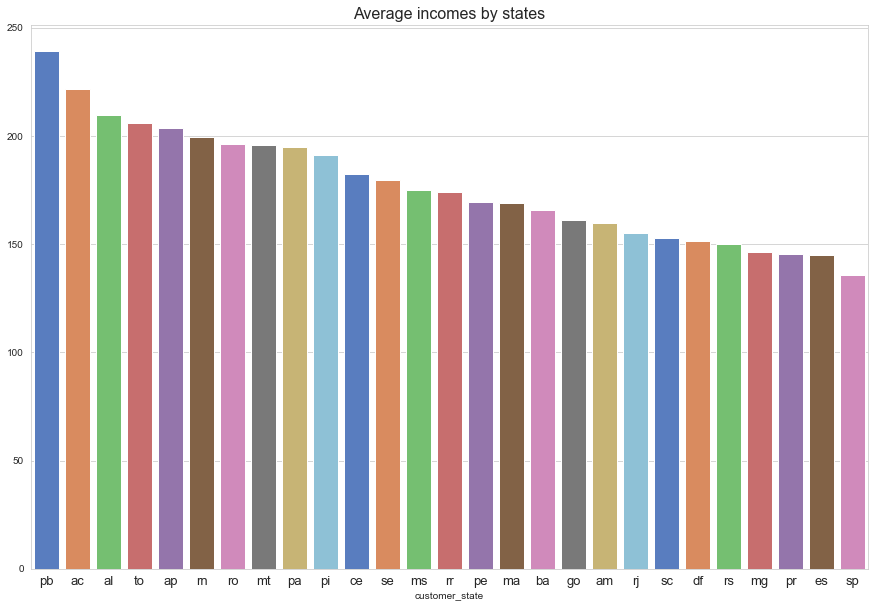

In [44]:
incomes_analysis(df, 'customer_state', 'Average incomes by states', lab_rot=0)

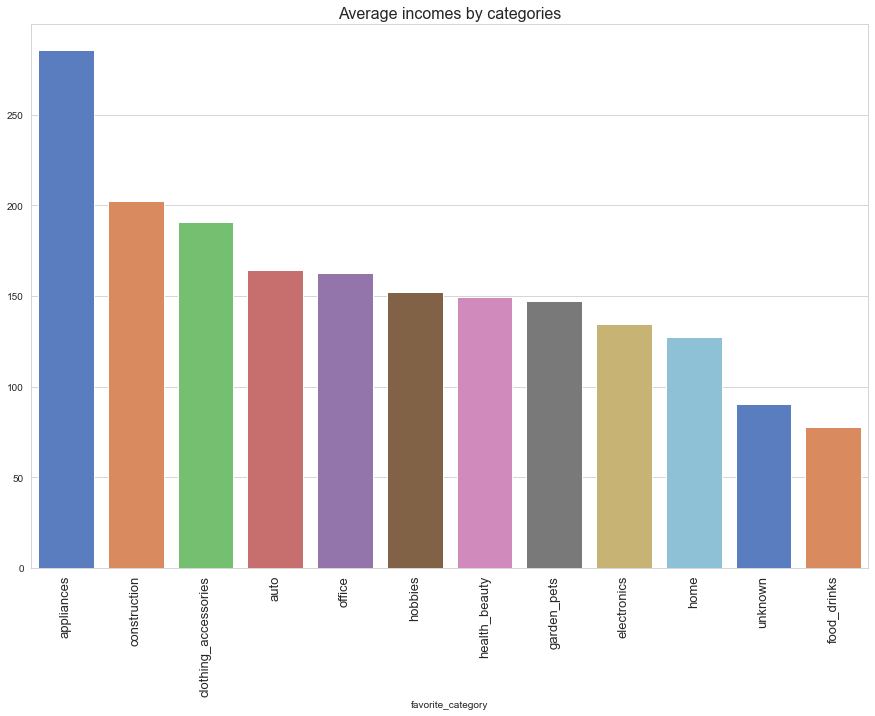

In [45]:
incomes_analysis(df, 'favorite_category', 'Average incomes by categories')

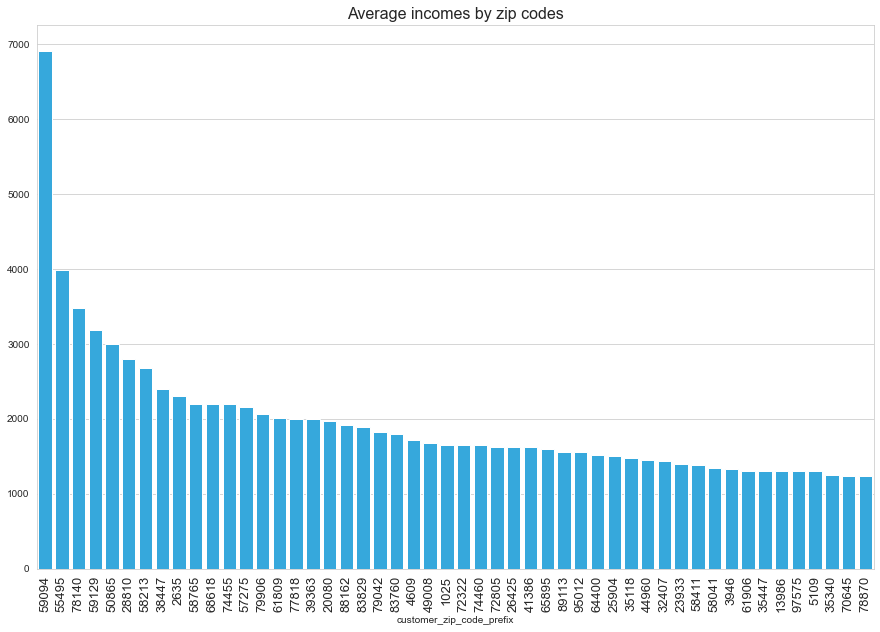

In [46]:
incomes_analysis(df, 'customer_zip_code_prefix', 'Average incomes by zip codes', top=50, color='#1bb2f7')

## Correlations

In [47]:
# convert datetime features to int
df['first_order_date'] = [np.int64(x.timestamp()) for x in df['first_order_date']]
df['customer_zip_code_prefix'] = df['customer_zip_code_prefix'].astype(int)

In [48]:
def show_corr(df):
    '''Display a correlation heatmap for the given dataframe
    df: DataFrame
    '''
    corr = df.corr(method="pearson")
    f, ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(corr,
                mask=np.zeros_like(corr, dtype=np.bool_),
                cmap="coolwarm",
                square=True,
                annot=True,
                ax=ax)
    plt.show()

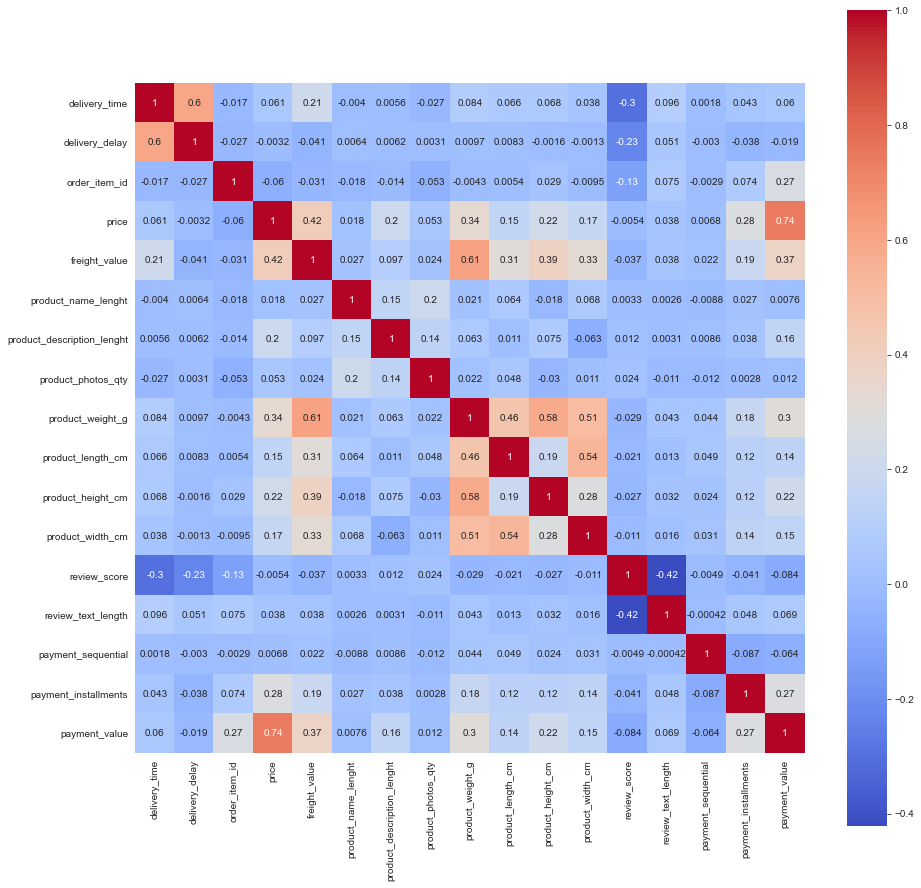

In [49]:
show_corr(db_df)

In [50]:
# removing column with too high correlations
df.drop(columns=['nb_reviews', 'mean_order_price', 'mean_nb_products', 'mean_product_price', 'first_order_date'], inplace=True)

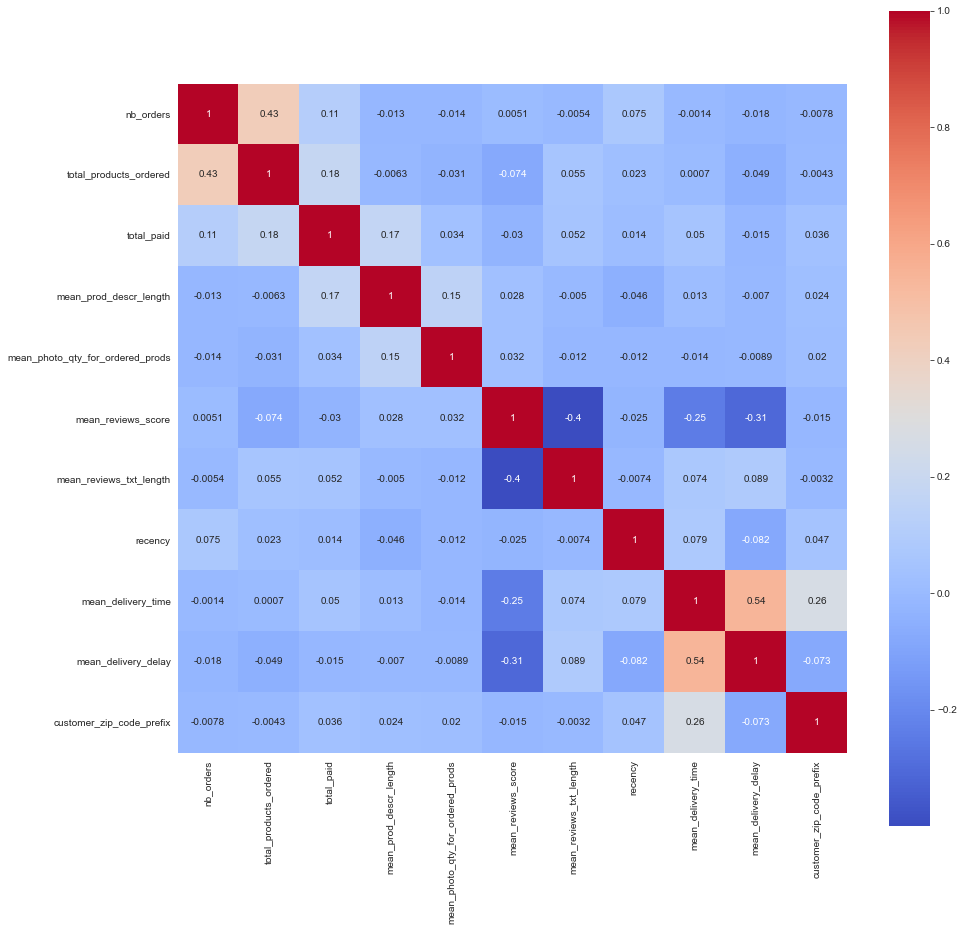

In [51]:
show_corr(df)

## Save Dataset as CSV

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96096 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nb_orders                         96096 non-null  int64  
 1   total_products_ordered            96096 non-null  float64
 2   total_paid                        96096 non-null  float64
 3   mean_prod_descr_length            96096 non-null  float64
 4   mean_photo_qty_for_ordered_prods  96096 non-null  float64
 5   mean_reviews_score                96096 non-null  float64
 6   mean_reviews_txt_length           96096 non-null  float64
 7   recency                           96096 non-null  int64  
 8   mean_delivery_time                96096 non-null  float64
 9   mean_delivery_delay               96096 non-null  float64
 10  favorite_category                 96096 non-null  object 
 11  favorite_payme

This data structure is to the one that will be used for the clustering.  
But I will have to recalculate some features for the temporal stability analysis so I export the dataset obtained after grouping the tables and I will define a method in the following notebook to recreate the final dataset

In [53]:
db_df.to_csv('POLIST_04_data/cleaned_grouped_tables.csv', sep=',', index=False)

In [54]:
print("Exported dataset : {} rows / {} columns".format(db_df.shape[0], db_df.shape[1]))

Exported dataset : 119151 rows / 44 columns
